# Pseudocode

 ## Cleaning:
    - NaN/?/Blank
        - waterfront
        - view
        - yr_rennovated
        - sqft_basement
    - whitespace *no issue
    - format to int/float
        - view
        - waterfront
        - condition
        - grade
        - sqft_basement
    - deal with dupes
        - several properties are listed more than once, suggesting they were bought/sold during this timeframe. 
    - categorical encoding
        - bedrooms
        - bathrooms
        - floors
        - zipcode
        - waterfront
        - view
        - condition
        - grade
    - duplicate properties
        - Located, need to decide how to treat. 
    - drop unused columns
        - lat/long once done with all other steps. Technically this combination is categorical.
        - date
        - sqft_basement? - 454 records do not have a value here--we would need to drop these records at a minimum.
    - save cleaned data
    
    
 ## Simple Model
     - add features
     - transform features (log transform?)
     
     
     
 ## Business Problem/Stakeholders
 
 We (Antom Research) are based in King County and working on a project for a real estate investment trust. They would like us to use our area expertise to advise them on what sort of properties are likely to maximize the value of their investment. They have been tight-lipped about their plans for the properties they purchase, so we do not know if they intend to buy and hold, rennovate, demolish and rebuild, etc.
 
   
     
     

## Data Understanding

## 

# Imports

In [1]:
# Importing packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import statsmodels.api as sm

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Simple Data - omitted columns recommended in project description


In [2]:
simple_housing = pd.read_csv('../data/kc_house_data.csv')

In [3]:
complexities = ['date', 'view', 'sqft_above', 'sqft_basement', 'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15']

In [4]:
simple_housing.drop(columns=complexities, inplace=True)

In [5]:
simple_housing.head()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,yr_built
0,7129300520,221900.0,3,1.00,1180,5650,1.0,NaN,Average,7 Average,1955
1,6414100192,538000.0,3,2.25,2570,7242,2.0,NO,Average,7 Average,1951
2,5631500400,180000.0,2,1.00,770,10000,1.0,NO,Average,6 Low Average,1933
3,2487200875,604000.0,4,3.00,1960,5000,1.0,NO,Very Good,7 Average,1965
4,1954400510,510000.0,3,2.00,1680,8080,1.0,NO,Average,8 Good,1987


In [6]:
# Add price per square foot feature
simple_housing['price_sqft'] = simple_housing['price'] / simple_housing['sqft_living']

In [7]:
# drop waterfront & confirm no NaNs
simple_housing = simple_housing.drop(columns='waterfront')
simple_housing.isna().sum()

id             0
price          0
bedrooms       0
bathrooms      0
sqft_living    0
sqft_lot       0
floors         0
condition      0
grade          0
yr_built       0
price_sqft     0
dtype: int64

In [8]:
# think about binning if we're going categorically. Sounds like numerical

In [9]:
simple_housing.head()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,yr_built,price_sqft
0,7129300520,221900.0,3,1.00,1180,5650,1.0,Average,7 Average,1955,188.050847
1,6414100192,538000.0,3,2.25,2570,7242,2.0,Average,7 Average,1951,209.338521
2,5631500400,180000.0,2,1.00,770,10000,1.0,Average,6 Low Average,1933,233.766234
3,2487200875,604000.0,4,3.00,1960,5000,1.0,Very Good,7 Average,1965,308.163265
4,1954400510,510000.0,3,2.00,1680,8080,1.0,Average,8 Good,1987,303.571429


In [10]:
# Identify catgeorical values & create new df with only the categorical columns.
categoricals = ['condition', 'grade']
cat_df = simple_housing[categoricals]
cat_df.head()

,condition,grade
0,Average,7 Average
1,Average,7 Average
2,Average,6 Low Average
3,Very Good,7 Average
4,Average,8 Good


In [11]:
# OneHot encoding for categorical variables. Drop first column to avoid perfect multicolinearity.
ohe = OneHotEncoder(drop='first')
categorical_cats = ohe.fit_transform(cat_df)
categorical_cats.todense()
categorical_df = pd.DataFrame(categorical_cats.todense(), columns=ohe.get_feature_names(categoricals))
categorical_df.head()

,condition_Fair,condition_Good,condition_Poor,condition_Very Good,grade_11 Excellent,grade_12 Luxury,grade_13 Mansion,grade_3 Poor,grade_4 Low,grade_5 Fair,grade_6 Low Average,grade_7 Average,grade_8 Good,grade_9 Better
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [12]:
# Confirm identical # of records before concatenating.
print(categorical_df.shape)
print(simple_housing.shape)

(21597, 14)
(21597, 11)


In [13]:
# Drop origical categorical columns, concatenate encoded columns.
data = simple_housing.drop(columns=categoricals)
kc_encoded = pd.concat([data.reset_index(drop=True), categorical_df.reset_index(drop=True)], axis=1)

In [14]:
# Confirm no new records added & categoricals are gone.
print(kc_encoded.shape)
kc_encoded.info()

(21597, 23)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   21597 non-null  int64  
 1   price                21597 non-null  float64
 2   bedrooms             21597 non-null  int64  
 3   bathrooms            21597 non-null  float64
 4   sqft_living          21597 non-null  int64  
 5   sqft_lot             21597 non-null  int64  
 6   floors               21597 non-null  float64
 7   yr_built             21597 non-null  int64  
 8   price_sqft           21597 non-null  float64
 9   condition_Fair       21597 non-null  float64
 10  condition_Good       21597 non-null  float64
 11  condition_Poor       21597 non-null  float64
 12  condition_Very Good  21597 non-null  float64
 13  grade_11 Excellent   21597 non-null  float64
 14  grade_12 Luxury      21597 non-null  float64
 15  grade_13 Mansion     215

In [15]:
# Save off encoded data
kc_encoded.to_csv('../data/kc_encoded.csv')

## Exploring kc_encoded

In [20]:
# define X, y
X = kc_encoded.drop(columns=['price_sqft', 'id'])
y = kc_encoded['price_sqft']

In [21]:
# Train / Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

In [22]:
# Train df so we can see X vs Y in training data.
train_df = pd.concat([X_train, y_train], axis=1)
train_df.shape

(14469, 22)

In [23]:
train_df.corr().price_sqft.sort_values(ascending=False)

price_sqft             1.000000
price                  0.556867
grade_11 Excellent     0.105241
condition_Very Good    0.098920
grade_12 Luxury        0.082054
grade_13 Mansion       0.054713
condition_Good         0.038213
grade_9 Better         0.036359
grade_6 Low Average    0.022802
grade_3 Poor           0.018028
grade_4 Low            0.016807
grade_5 Fair           0.016577
floors                 0.004524
condition_Poor        -0.009636
condition_Fair        -0.022040
grade_8 Good          -0.038793
sqft_lot              -0.040317
bathrooms             -0.086735
sqft_living           -0.091328
grade_7 Average       -0.092049
bedrooms              -0.211009
yr_built              -0.296771
Name: price_sqft, dtype: float64

In [34]:
# add constant term/y-intercept
predictors = sm.add_constant(train_df)

In [39]:
X = train_df.drop(columns=['price_sqft'])
y = train_df['price_sqft']
model = sm.OLS(endog=y, exog=X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:             price_sqft   R-squared (uncentered):                   0.967
Model:                            OLS   Adj. R-squared (uncentered):              0.967
Method:                 Least Squares   F-statistic:                          2.038e+04
Date:                Tue, 21 Jun 2022   Prob (F-statistic):                        0.00
Time:                        14:25:30   Log-Likelihood:                         -77627.
No. Observations:               14469   AIC:                                  1.553e+05
Df Residuals:                   14448   BIC:                                  1.555e+05
Df Model:                          21                                                  
Covariance Type:            nonrobust                                                  
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
price                   0.0004   1.84e-06    205.925      0.000       0.000       0.000
bedrooms               -6.0860      0.625     -9.737      0.000      -7.311      -4.861
bathrooms             -12.5108      0.980    -12.760      0.000     -14.433     -10.589
sqft_living            -0.1073      0.001   -103.453      0.000      -0.109      -0.105
sqft_lot             6.251e-05   1.08e-05      5.797      0.000    4.14e-05    8.36e-05
floors                  3.6145      1.003      3.604      0.000       1.648       5.581
yr_built                0.1650      0.002     84.394      0.000       0.161       0.169
condition_Fair        -20.3206      4.848     -4.191      0.000     -29.824     -10.818
condition_Good          2.4243      1.053      2.301      0.021       0.359       4.489
condition_Poor        -20.2529     12.689     -1.596      0.111     -45.126       4.620
condition_Very Good     7.4226      1.676      4.430      0.000       4.138      10.707
grade_11 Excellent    -21.5746      3.765     -5.730      0.000     -28.954     -14.195
grade_12 Luxury      -103.8041      7.173    -14.471      0.000    -117.865     -89.743
grade_13 Mansion     -451.7444     20.384    -22.162      0.000    -491.699    -411.790
grade_3 Poor          147.4734     51.889      2.842      0.004      45.764     249.182
grade_4 Low            20.0983     13.299      1.511      0.131      -5.970      46.166
grade_5 Fair           -2.9783      4.950     -0.602      0.547     -12.681       6.724
grade_6 Low Average    -9.2862      3.079     -3.016      0.003     -15.321      -3.251
grade_7 Average        -6.4148      2.578     -2.488      0.013     -11.468      -1.362
grade_8 Good            3.0389      2.366      1.284      0.199      -1.598       7.676
grade_9 Better         10.9459      2.331      4.697      0.000       6.378      15.514
==============================================================================
Omnibus:                     4116.622   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           131953.178
Skew:                           0.727   Prob(JB):                         0.00
Kurtosis:                      17.723   Cond. No.                     7.92e+07
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 7.92e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

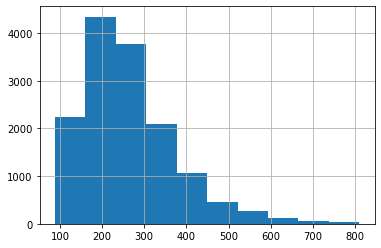

In [36]:
y.hist();

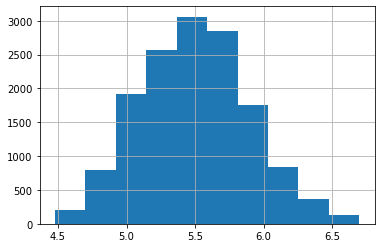

In [37]:
y_scld=np.log(y)
y_scld.hist();

In [38]:
# Model with log-scaled y. R-squared improved ~3 points

X = train_df.drop(columns=['price_sqft'])
y = np.log(train_df['price_sqft'])
model2 = sm.OLS(endog=y, exog=X).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:             price_sqft   R-squared (uncentered):                   0.998
Model:                            OLS   Adj. R-squared (uncentered):              0.998
Method:                 Least Squares   F-statistic:                          4.437e+05
Date:                Tue, 21 Jun 2022   Prob (F-statistic):                        0.00
Time:                        14:25:13   Log-Likelihood:                          1586.8
No. Observations:               14469   AIC:                                     -3132.
Df Residuals:                   14448   BIC:                                     -2972.
Df Model:                          21                                                  
Covariance Type:            nonrobust                                                  
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
price                1.378e-06    7.7e-09    179.006      0.000    1.36e-06    1.39e-06
bedrooms               -0.0157      0.003     -6.000      0.000      -0.021      -0.011
bathrooms              -0.0711      0.004    -17.293      0.000      -0.079      -0.063
sqft_living            -0.0004   4.35e-06    -90.307      0.000      -0.000      -0.000
sqft_lot             2.804e-07   4.52e-08      6.204      0.000    1.92e-07    3.69e-07
floors                 -0.0020      0.004     -0.485      0.627      -0.010       0.006
yr_built                0.0029   8.19e-06    356.086      0.000       0.003       0.003
condition_Fair         -0.0788      0.020     -3.878      0.000      -0.119      -0.039
condition_Good          0.0324      0.004      7.346      0.000       0.024       0.041
condition_Poor         -0.0524      0.053     -0.984      0.325      -0.157       0.052
condition_Very Good     0.0926      0.007     13.186      0.000       0.079       0.106
grade_11 Excellent     -0.0875      0.016     -5.543      0.000      -0.118      -0.057
grade_12 Luxury        -0.4122      0.030    -13.710      0.000      -0.471      -0.353
grade_13 Mansion       -1.8021      0.085    -21.093      0.000      -1.970      -1.635
grade_3 Poor            0.4391      0.217      2.019      0.044       0.013       0.865
grade_4 Low             0.0609      0.056      1.092      0.275      -0.048       0.170
grade_5 Fair            0.0021      0.021      0.103      0.918      -0.039       0.043
grade_6 Low Average     0.0049      0.013      0.378      0.706      -0.020       0.030
grade_7 Average        -0.0085      0.011     -0.784      0.433      -0.030       0.013
grade_8 Good            0.0245      0.010      2.474      0.013       0.005       0.044
grade_9 Better          0.0526      0.010      5.380      0.000       0.033       0.072
==============================================================================
Omnibus:                     4760.913   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            82637.572
Skew:                          -1.126   Prob(JB):                         0.00
Kurtosis:                      14.489   Cond. No.                     7.92e+07
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 7.92e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [40]:
kc_encoded['condition_Poor'].sum()

# Maybe drop since pvalues are very high and minimal number of properties.

29.0

In [41]:
kc_encoded['grade_8 Good'].sum()

# Too big a population to drop.

6065.0

## Visualizing

In [ ]:
fig, axes = plt.subplots(nrows=6, ncols=4, figsize=(16,20))


for xcol, ax in zip(kc_encoded.columns[:], [x for v in axes for x in v]):
    kc_encoded.plot.scatter(x=xcol, y='price_sqft', ax=ax, alpha=0.5, color='b')


In [ ]:
import warnings
warnings.filterwarnings('ignore')
fig = plt.figure(figsize = (15,15))
ax = fig.gca()
kc_encoded.hist(ax = ax);

In [ ]:
y.hist();

In [ ]:
y_scld = np.log(y)
y_scld.hist();

In [ ]:
model2 = sm.OLS(y_scld, X).fit()
model2.summary()

# Full EDA

In [ ]:
kc_housing = pd.read_csv('../data/kc_house_data.csv')


In [ ]:
kc_housing.shape

In [ ]:
kc_housing.describe()

In [ ]:
columns_of_note = list(kc_housing.columns)[3:8]

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(16,16))


for xcol, ax in zip(kc_housing.columns[3:8], [x for v in axes for x in v]):
    kc_housing.plot.scatter(x=xcol, y='price', ax=ax, alpha=0.5, color='b')


In [ ]:
import warnings
warnings.filterwarnings('ignore')
fig = plt.figure(figsize = (15,15))
ax = fig.gca()
kc_housing.hist(ax = ax);

In [ ]:
kc_housing.info()

In [ ]:
# Looking for NANs
kc_housing.isna().sum()

#### Added price/sqft feature

In [ ]:
kc_housing['price_sqft'] = kc_housing['price']/kc_housing['sqft_living']

In [ ]:
kc_housing.head()

#### Addressing Waterfront

There are ~2400 NA cells, no easy way to determine if waterfront or not. Recommend we drop this whole column--even if all of the NA cells should be YES for waterfront, that's less than 10% of our dataset, likely not meaningful to our analysis.

Drop Waterfront.

In [ ]:
kc_housing['waterfront'].value_counts()

In [ ]:
sum(kc_housing['waterfront'].isna())

In [ ]:
kc_housing['waterfront'] = kc_housing['waterfront'].fillna('N/A')

In [ ]:
kc_housing.sort_values(by='waterfront', ascending=False)

#### Addressing View

Doesn't seem to be many rows with na. Maybe encode as NA or preferably drop?+

Drop rows with N/A

In [ ]:
sum(kc_housing['view'].isna())

In [ ]:
kc_housing['view'].value_counts()

In [ ]:
# code to replace empty with N/A - add inplace if we decide to take this approach.
kc_housing['view'] = kc_housing['view'].fillna('N/A')

#### Addressing yr_renovated

Absent from simple data, maybe we add on later

~ 78% have 0 values, so assume they were not rennovated. I think rennovations are a meaningful datapoint, so we should encode this somehow. We could think about how recent the rennovation was to see if there is a meaningful relationship--for example, a home rennovated in 2020 is likely to sell better than a home rennovated only in 1980. Maybe we do some research on this and decide on a breakpoint for rennovated before/after? We could do a simple linear regression between yr renovated and price...

In [ ]:
sum(kc_housing['yr_renovated'].isna())

In [ ]:
kc_housing['yr_renovated'].value_counts(sort=False).head(75)

In [ ]:
kc_housing['yr_renovated'] = kc_housing['yr_renovated'].fillna('N/A')

In [ ]:
#dropping N/A for now to make model function.
kc_housing = kc_housing[(kc_housing.yr_renovated != 'N/A')]

#### Duplicate Properties

In [ ]:
# Looking for duplicate properties

kc_housing['id'].duplicated().sum()

In [ ]:
# Identify instances of the same property appearing more than once in the data set based on lattitude, longitude
# How do we treat this? Might not matter since there is only ~4-5 months of data here. as long as listing date 
# is different, probably OK to treat these as unique listings.


kc_housing[kc_housing.duplicated(subset=['id'], keep=False)].sort_values('id')

#### Addressing grade

This we need to encode as an ordinal.

In [ ]:
kc_housing['grade'].value_counts()

In [ ]:
# Create new column for numerical grade. 
# Should either drop df['grade'] or omit it from clean df.
kc_housing['grade_num']= kc_housing['grade'].apply(lambda x: x[:1]).astype(int)

In [ ]:
kc_housing['grade_num']

In [ ]:
kc_housing.info()

#### Addressing sqft_basement

Recommend we drop rows with N/A since we don't have an easy way to encode.
We have 454 unknown values here. need to drop or encode somehow. Maybe has basement or no basement?


In [ ]:
kc_housing['sqft_basement'].value_counts()

In [ ]:
kc_housing = kc_housing[(kc_housing.sqft_basement != '?')]

In [ ]:
kc_housing['sqft_basement'].value_counts()

# Encoding Categoricals

In [ ]:
# Identify catgeorical values & create new df with only the categorical columns.
categoricals = ['bedrooms', 'floors', 'condition', 'grade', 'view','waterfront']
cat_df = kc_housing[categoricals]
cat_df.head()

In [ ]:
# OneHot encoding for categorical variables. Drop first column to avoid perfect multicolinearity.
ohe = OneHotEncoder(drop='first')
categorical_cats = ohe.fit_transform(cat_df)
categorical_cats.todense()
categorical_df = pd.DataFrame(categorical_cats.todense(), columns=ohe.get_feature_names(categoricals))
categorical_df.head()

In [ ]:
categorical_df.shape

In [ ]:
kc_housing.shape

In [ ]:
# Append categorical dummies to original dataframe, and drop origical categorical columns.
data = kc_housing.drop(columns=categoricals)
kc_encoded = pd.concat([data.reset_index(drop=True), categorical_df.reset_index(drop=True)], axis=1)

In [ ]:
kc_encoded.shape

In [ ]:
kc_encoded.info()

# Nonsense Model with all columns

In [ ]:
X = kc_encoded.drop(columns=['date', 'lat', 'long', 'id','price_sqft','yr_renovated','sqft_basement'])
y = kc_encoded['price_sqft']

In [ ]:
X.isna().sum()

In [ ]:

model = sm.OLS(endog=y, exog=X).fit()
model.summary()